In [ ]:
import torch
import wandb
import torchvision

import numpy as np

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

import os
%config InlineBackend.figure_format='retina'

In [ ]:
device = torch.device('cuda')
classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./ddpm_checkpoints/classifier.pth'))

clean_classifier = ResNet(**classifier_args)
clean_classifier.to(device)

clean_classifier.load_state_dict(torch.load('./ddpm_checkpoints/clean_classifier.pth'))

<All keys matched successfully>

#### Создайте два семплемера картинок, безусловный и условный с методом .set_classifier

In [ ]:
conditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)
conditional_diffusion.set_classifier(noisy_classifier, T=1.)

unconditional_diffusion = DiffusionRunner(create_default_mnist_config(), eval=True)

In [ ]:
conditional_diffusion.model.eval()
unconditional_diffusion.model.eval();

In [ ]:
def get_pred_labels(images_normed: torch.Tensor):
    """
    predict labels for normed images 
    [-1, 1]
    """
    images_normed = images_normed.to(device)
    return clean_classifier(images_normed).argmax(dim=-1)


def calc_acc_clean_classifier(images_normed: torch.Tensor, labels: torch.Tensor):
    """
    calculate accuracy using clean classifier
    """
    labels = labels.to(device)
    preds = get_pred_labels(images_normed)
    acc = (preds==labels).sum() / labels.shape[0]
    return acc


def sample_images(diff_process, labels=None, show=False):
    images_tensor = diff_process.sample_images(batch_size=100, labels=labels)
    images_cpu = images_tensor.cpu()
    grid = torchvision.utils.make_grid(images_cpu, nrow=10).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)

    if show:
        plt.imshow(grid)
        plt.show()
    return images_tensor


def cond_print_and_calc_acc(class_num: int, show: bool=False):
    labels = class_num*torch.ones(100).long().to(device)
    images_tensor = sample_images(conditional_diffusion, labels, show)
    acc = calc_acc_clean_classifier((images_tensor - 127.5)/ 127.5, labels=labels)
    print(f'Num: {class_num}, Accuracy:', round(acc.item(), 3))
    return images_tensor

#### Посемплируйте наборы картинок всех классов обоими способами, изменить температуру можно с помощью повторного .set_classifier

In [ ]:
uniform_labels = torch.arange(10, dtype=torch.long, device=device) * torch.ones(10, dtype=torch.long, device=device).view(-1, 1)
print(uniform_labels)
uniform_labels = uniform_labels.flatten()

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], device='cuda:0')


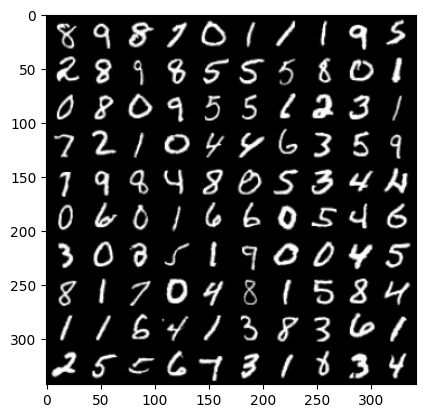

In [ ]:
sample_images(unconditional_diffusion, show=True);

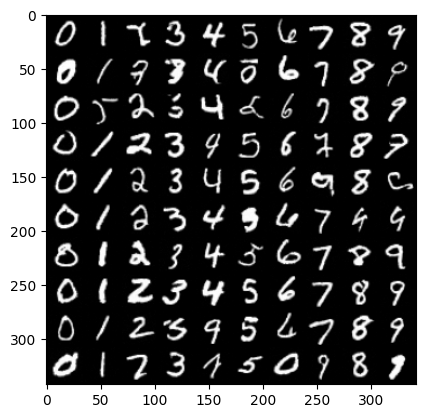

In [ ]:
T = 1
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)
sample_images(conditional_diffusion, uniform_labels, show=True);

> Как сильно влияет температура на отличимость семплов при условной генерации? Продеменстрируйте для разных T свои выводы.



Попробуем температуру поменьше:

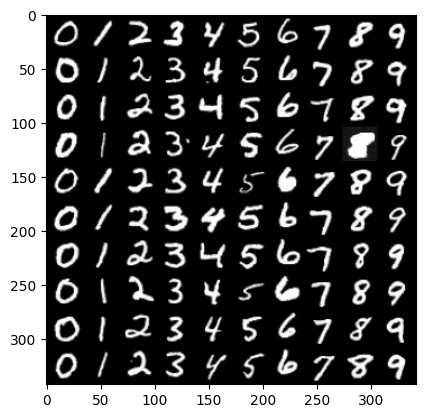

In [ ]:
T = 0.1
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)
sample_images(conditional_diffusion, uniform_labels, show=True);

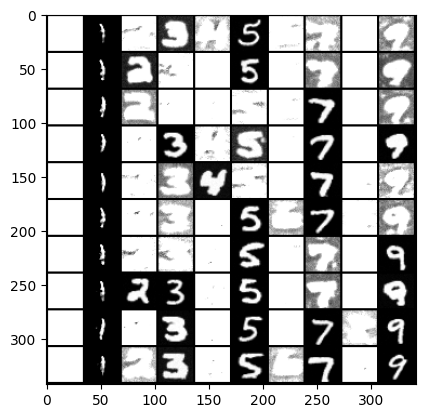

In [ ]:
T = 0.001
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)
sample_images(conditional_diffusion, uniform_labels, show=True);

И температуру побольше:

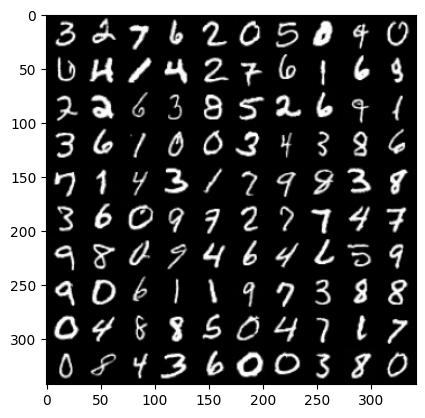

In [ ]:
T = 10
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)
sample_images(conditional_diffusion, uniform_labels, show=True);

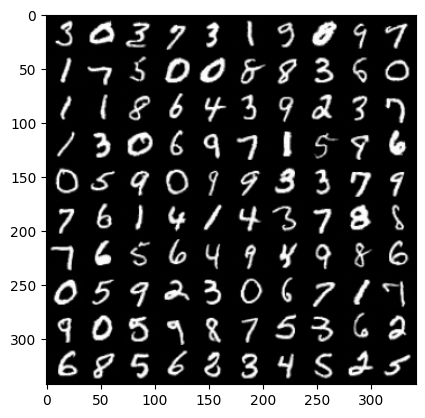

In [ ]:
T = 100
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)
sample_images(conditional_diffusion, uniform_labels, show=True);

Вообще температура задаёт неуверенность классификатора в предсказаниях (на неё делятся логиты), но нам было сказано просто делить часть классификатора в скоре на неё (то есть она будет обратным коэффициентом classifier guidance).

**Выводы:** Как и ожидалось, увелечение температуры превращает генерацию картинок в безусловную, тут ничего удивительного. Интереснее уменьшение температуры: при совсем маленьких значениях ($T = 0.01$) классификатор перевешивает диффузионную модель и картинки выглядят ужасно, хотя классы получается различить достаточно точно. При этом $T = 0.1$ показывает лучшую точность, чем дефолтный $T = 1$ (модель не путает схожие цифры вроде 9 и 4), хотя качество кое-где чуть падает. При этом цифры также становятся более однообразными. Очевидно, что нужно соблюсти некоторый баланс качества изображений и точностью класса, правильно подобрав температуру.

Далее используем значение $T=0.5$, чтобы получить баланс между близостью к классу и качеством семплов.

> Какое качество получается у чистого классификатора при условной генерации? Попробуйте оценить на глаз качество чистого классификатора для безусловной генерации, объясните свои выводы.


In [ ]:
conditional_diffusion.set_classifier(noisy_classifier, T=0.5)
for i in range(10):
    cond_print_and_calc_acc(i, show=False)

Num: 0, Accuracy: 0.99
Num: 1, Accuracy: 1.0
Num: 2, Accuracy: 0.97
Num: 3, Accuracy: 0.99
Num: 4, Accuracy: 1.0
Num: 5, Accuracy: 0.96
Num: 6, Accuracy: 1.0
Num: 7, Accuracy: 0.99
Num: 8, Accuracy: 0.98
Num: 9, Accuracy: 1.0


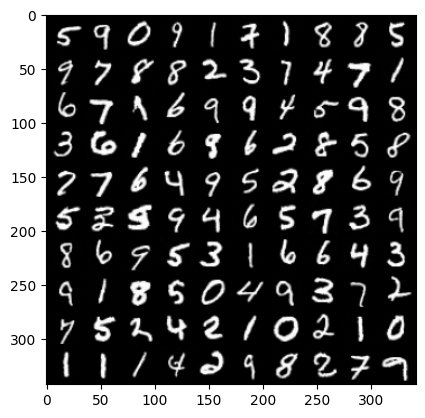

In [ ]:
images = sample_images(unconditional_diffusion, show=True)

In [ ]:
preds = clean_classifier((images - 127.5)/ 127.5).argmax(dim=-1)
preds.view(10,10)

tensor([[5, 9, 0, 9, 1, 7, 1, 8, 8, 5],
        [9, 7, 8, 8, 2, 3, 7, 4, 7, 1],
        [6, 7, 1, 6, 9, 9, 4, 5, 9, 8],
        [3, 6, 1, 6, 8, 6, 2, 8, 5, 8],
        [7, 7, 6, 4, 9, 5, 2, 8, 6, 9],
        [5, 2, 9, 9, 4, 6, 5, 7, 3, 9],
        [8, 6, 9, 5, 3, 1, 6, 6, 4, 3],
        [9, 1, 8, 5, 0, 4, 9, 3, 7, 2],
        [7, 5, 2, 4, 2, 1, 0, 2, 1, 0],
        [1, 1, 1, 4, 2, 9, 8, 2, 7, 9]], device='cuda:0')

Я увидел две ошибки из 100 (тройку перепутал с двойкой в [5, 0] и девятку с восьмеркой в [3, 4]), т.е. точность около **0.98**.

##### Альтернативное решение

Возможно я неправильно понял задание, и требовалось просемплировать картинки условно, но с чистым классификатором (мне так и не ответили на вопрос в чате курса). Давайте попробуем:

In [ ]:
# вообще говоря не вполне честно измерять качество тем же классификатором, что направляет скор
# тем не менее это не слишком помогает ему поднять качество

conditional_diffusion.set_classifier(clean_classifier, T=0.5)
for i in range(10):
    cond_print_and_calc_acc(i, show=False)

Num: 0, Accuracy: 0.13
Num: 1, Accuracy: 0.16
Num: 2, Accuracy: 0.16
Num: 3, Accuracy: 0.02
Num: 4, Accuracy: 0.12
Num: 5, Accuracy: 0.08
Num: 6, Accuracy: 0.1
Num: 7, Accuracy: 0.1
Num: 8, Accuracy: 0.16
Num: 9, Accuracy: 0.12


Качество на большинстве классов около случайной генерации (0.1).

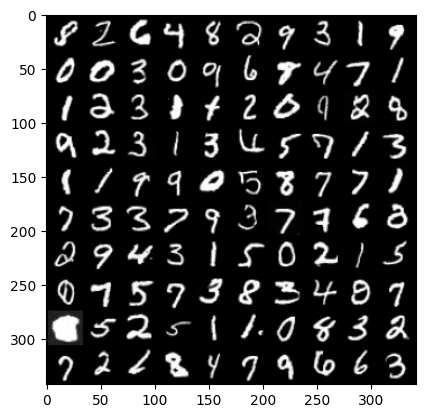

In [ ]:
sample_images(conditional_diffusion, uniform_labels, show=True);

Как и ожидалось, получилось не очень, потому что классификатору трудно направлять градиент на зашумленных картинках, когда он учился на чистых (out of domain).

## ODE генерация (DDIM)

### Уменьшение N

#### SDE

Картинки семплируются достаточно долго. Уменьшая N мы пропорционально уменьшим время генерации, но качество генерируемых картинок может упасть.

Для начала может быть полезно визуализировать как меняется расписание шума диффузионного процесса:

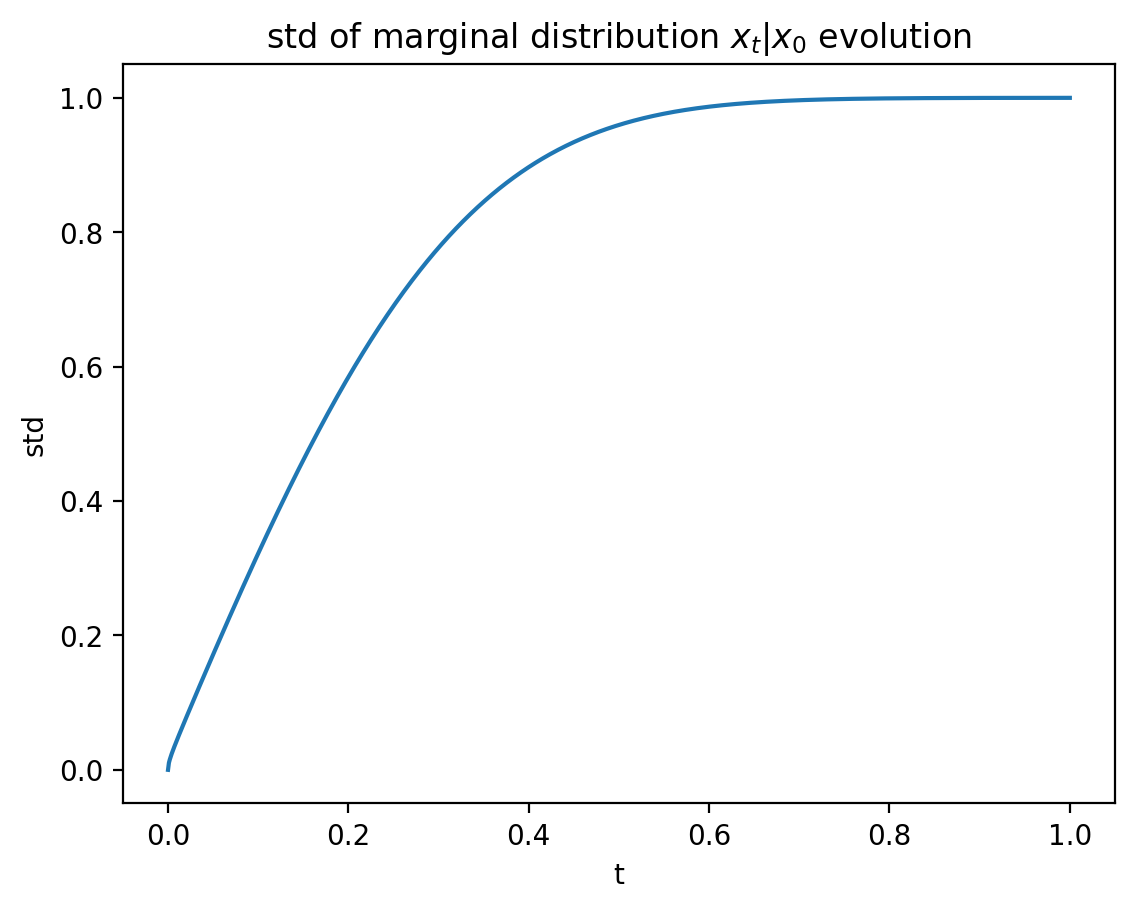

In [ ]:
t_grid = torch.linspace(0, 1, 1000)
beta_0 = conditional_diffusion.sde.beta_0
beta_1 = conditional_diffusion.sde.beta_1
B = (beta_1 - beta_0) * t_grid**2/2 + beta_0 * t_grid
std = torch.sqrt(1-torch.exp(-B))

plt.plot(t_grid, std)
plt.xlabel("t")
plt.ylabel("std")
plt.title(r"std of marginal distribution $x_t | x_0$ evolution");

Как видим шум быстро растёт в первую половину, а затем уже сильно медленнее. Возможно было бы логично семплировать t не равномерно, а в основном в левой части.

Теперь попробуем различные N и посмотрим как меняется качество:

In [ ]:
def sample_multiple_N(diff_process, labels=None, N_arr=[1000]):
    num_N = len(N_arr)
    # figsize для colab'а, в юпитере могут выглядеть иначе в зависимости от настроек
    fig, axs = plt.subplots(ncols=num_N, figsize=(30, 30*num_N))
    for i, N in enumerate(N_arr):
        diff_process.sde.N = N
        diff_process.diff_eq_solver.rsde.N = N

        # the rest is same as sample_images
        images_tensor = diff_process.sample_images(batch_size=100, labels=labels)
        images_cpu = images_tensor.cpu()
        grid = torchvision.utils.make_grid(images_cpu, nrow=10).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)

        axs[i].axis('off') 
        axs[i].imshow(grid)
        axs[i].set(title=f"N = {N}")
    # fig.show()

In [ ]:
# Дефолтные настройки
T = 0.5
N = 1000
config = create_default_mnist_config()
conditional_diffusion = DiffusionRunner(config, eval=True)
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)

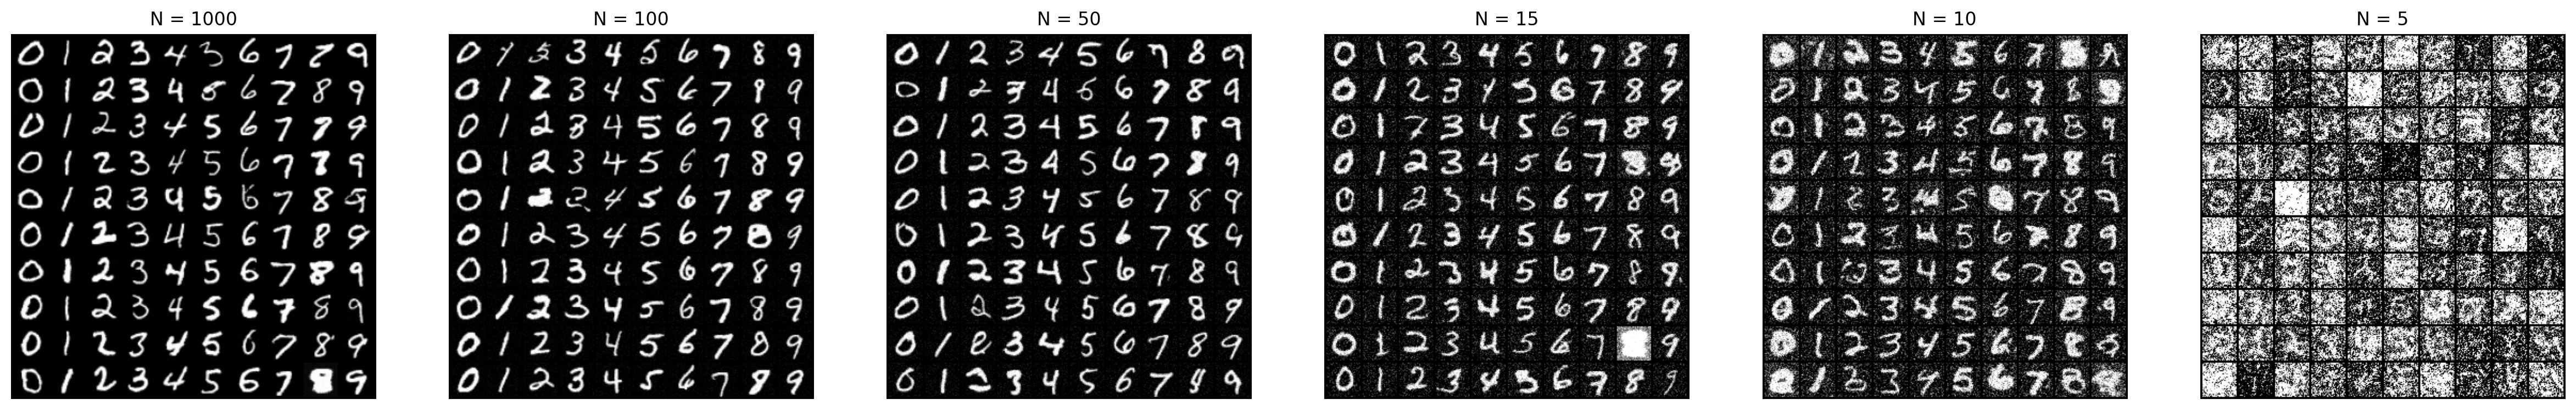

In [ ]:
sample_multiple_N(conditional_diffusion, labels=uniform_labels, N_arr=[1000, 100, 50, 15, 10, 5])

Если сравнивать "на глаз", то значения $N \approx 50$ кажутся наиболее хорошими с точки зрения цена-качество.

#### ODE 

DDIM (т.е. решение через обыкновенное дифференциальное уравнение) известен именно тем, что позволяет лучше уменьшать число шагов N. Давайте попробуем его на практике.

In [ ]:
T = 0.5
config = create_default_mnist_config()
config.training.ode_sampling = True
conditional_diffusion = DiffusionRunner(config, eval=True)
conditional_diffusion.set_classifier(noisy_classifier.eval(), T=T)

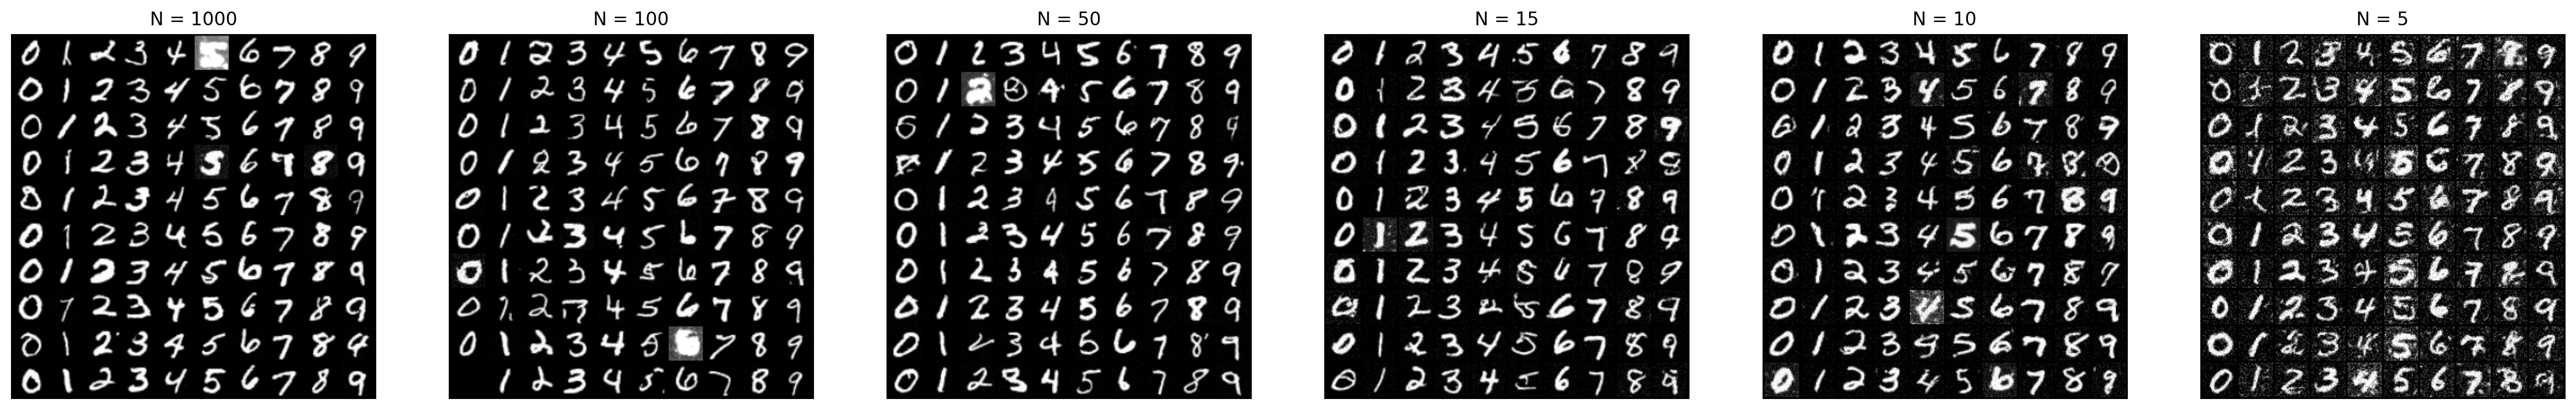

In [ ]:
sample_multiple_N(conditional_diffusion, labels=uniform_labels, N_arr=[1000, 100, 50, 15, 10, 5])

**Выводы:** Действительно стало сильно лучше для маленьких N. Тем не менее в целом кажется, что качество для больших N несколько хуже: многие картинки получаются с артефактами. Возможно проблема в приближении схемой Эйлера.

### Интерполяция изображений с помощью ODE

У DDIM есть ещё одно преимущество: взаимооднозначное соотвествие шума и изображений. В частности это можно использовать, чтобы получать осмысленную интерполяцию между двумя изображениями: сначала оба изображения отображаются в шум, затем там берется их линейная интерполяция с весами $w, 1-w$, где $w \in [0, 1]$, затем отображаются обратно в пространство изображений.

В этой части мы работаем с **безусловной диффузией через ODE**.

Давайте попробуем:

Сначала возьмём по картинке из каждого класса, чтобы далее их можно было интерполировать:

In [ ]:
T = 0.5
N = 100

config = create_default_mnist_config()
config.training.ode_sampling = True
ode_diffusion = DiffusionRunner(config, eval=True)
ode_diffusion.set_classifier(noisy_classifier.eval(), T=T)

ode_diffusion.sde.N = N
ode_diffusion.diff_eq_solver.rsde.N = N

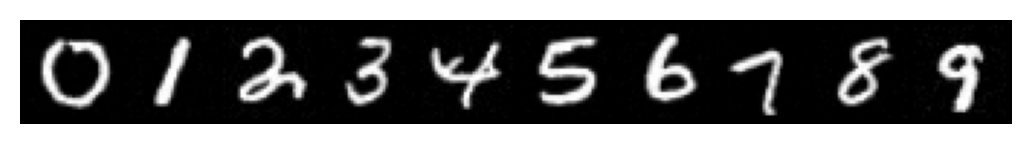

In [ ]:
labels= torch.arange(10).to(device)

reference_imgs = ode_diffusion.sample_images(batch_size=10, labels=labels).cpu()
grid = torchvision.utils.make_grid(reference_imgs, nrow=10).permute(1, 2, 0)
grid = grid.data.numpy().astype(np.uint8)

plt.axis("off")
plt.imshow(grid)
plt.show()

In [ ]:
ode_diffusion.reset_unconditional_sampling() # убираем classifier guidance

Напишем функции отображения из картинок в шум и обратно (аналогично `sample_images` из `diffusion.py`).

In [ ]:
@torch.no_grad()
def img_to_noise(class_num, diff_process, N=100, eps=1e-4):
    """
        Turns reference_imgs of class_num class into noise using diffusion process
    """
    img = reference_imgs[class_num]
    diff_process.sde.N = N
    diff_process.diff_eq_solver.rsde.N = N

    t_range = diff_process.sde.T * np.arange(N) / N
    # print(t_range)
    x = (img - 127.5)/ 127.5
    x = x.unsqueeze(0).to(device)
    for t in t_range:
        t = torch.tensor([t+eps], device=device).float()
        x, m = diff_process.diff_eq_solver.step(x, t, backward=False)
    return x


@torch.no_grad()
def noise_to_img(noise, diff_process, N=100):
    """
        Turns given noise to img using diffusion process
    """
    diff_process.sde.N = N
    diff_process.diff_eq_solver.rsde.N = N

    t_range = diff_process.sde.T * (N - np.arange(N)) / N
    # print(t_range)
    x = noise
    for t in t_range:
        t = torch.tensor([t], device=device).float()
        x, _ = diff_process.diff_eq_solver.step(x, t, backward=True)
    img = diff_process.inverse_scaler(x).cpu()[0].permute(1, 2, 0).numpy().astype(np.uint8)
    return img

In [ ]:
def interpolate(class_A, class_B, diff_process, n_imgs=15, N=100):
    """
        shows n_imgs images interpolated between class_A and class_B images from reference_imgs array
    """
    noise_A = img_to_noise(class_A, diff_process, N)
    noise_B = img_to_noise(class_B, diff_process, N)
    fig, axs = plt.subplots(ncols=n_imgs, figsize=(10, 10*n_imgs))
    interpolation_weights = torch.linspace(0, 1, n_imgs)
    for i, w in enumerate(interpolation_weights):
        noise = noise_A * (1-w) + noise_B * w
        img = noise_to_img(noise, diff_process, N)
        axs[i].axis('off') 
        axs[i].imshow(img, cmap='gray')
        axs[i].set(title=round(w.item(), 2))

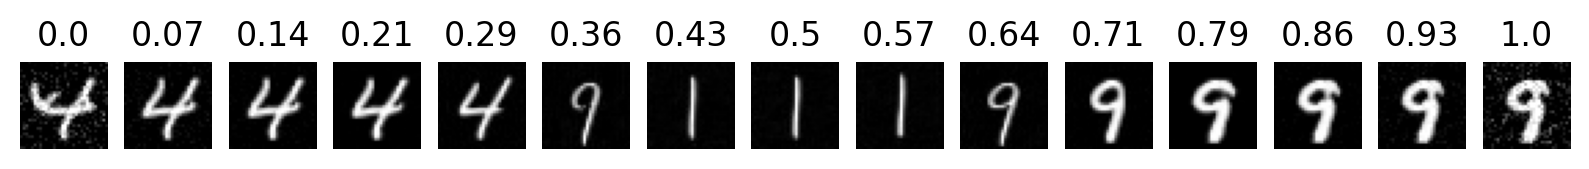

In [ ]:
interpolate(4, 9, ode_diffusion)

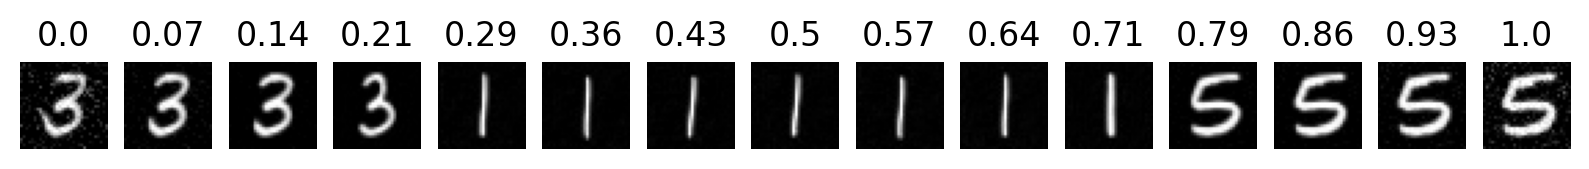

In [ ]:
interpolate(3, 5, ode_diffusion)

К сожалению не получилось плавных переходов как я надеялся. Но можно посмотреть что будет, если вместо этого использовать **SDE**:

In [ ]:
T = 0.5
N = 100

config = create_default_mnist_config()
sde_diffusion = DiffusionRunner(config, eval=True)

sde_diffusion.sde.N = N
sde_diffusion.diff_eq_solver.rsde.N = N

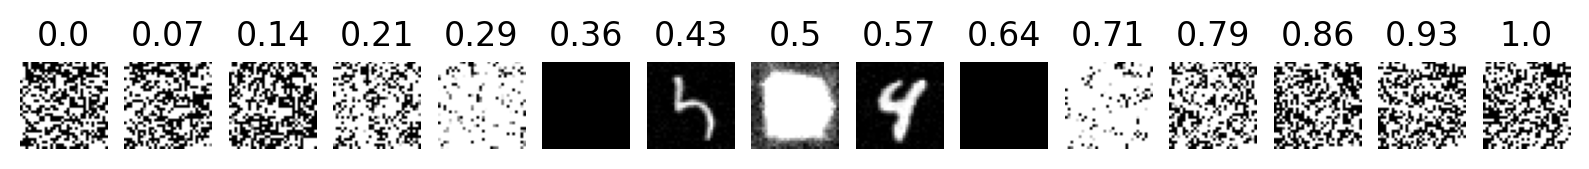

In [ ]:
interpolate(4, 9, sde_diffusion)

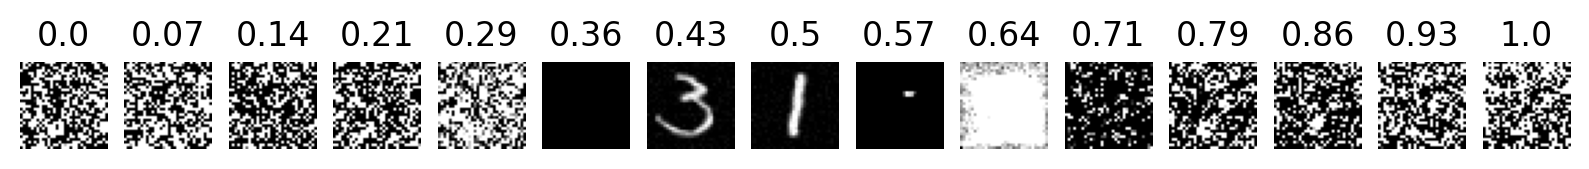

In [ ]:
interpolate(3, 5, sde_diffusion)

Вот тут совсем беда получилась, так что преимущество у ODE всё же есть, хоть и не вышло плавной интерполяции. Возможно плавности нет из-за того, что сетке удалось переобучиться на MNIST, и границы классов получились сильно резкими.

### Теоретические выкладки


Прямой процесс задаётся стохастическим диффуром:

$$
    dx_t = -\frac{1}{2}\beta(t) x_t dt + \sqrt{\beta(t)} dW_t
$$

На семинаре по стохдиффурам решали аналогичное уравнение для $\beta(t) = \beta$, сделали замену $y = x exp(\beta t/2)$. 

---

Попробуем в нашем случае аналогично посмотреть на решение диффура без стохастической части:

\begin{gather*}
    dx_t = -\frac{1}{2}\beta(t)x_t dt\\
    \Downarrow\\
    \ln x_t = -\frac{1}{2}\underbrace{\int\limits_{0}^t \beta(s)ds}_{B(t)} + C
\end{gather*}

То есть $B(t)$ - первообразная $\beta(t)$, причем $B(0) = 0$.


Подставляя начальную точку получаем решение:

$$
    \boxed{x_t = x_0 e^{-B(t)/2}}
$$

---

Вернёмся к стохдиффуру, сделаем замену:

$$
    y_t = x_t e^{B(t)/2}
$$

По формуле Ито получаем стохдиффур на $y_t$:

\begin{gather*}
    dy_t = \left(e^{B(t)/2}\beta(t)/2 + -\beta(t)e^{B(t)/2}/2 + 0\right) + e^{B(t)/2}\sqrt{\beta(t)} dW_t\\
    \boxed{dy_t = e^{B(t)/2}\sqrt{\beta(t)} dW_t}
\end{gather*}

Благодаря тому, что мы подставили решение обычного диффура, нестохастическая часть сократилась. Аналогично семинару получаем:

\begin{gather*}
    \mathbb{E}[y_t] = y_0 = x_0\\
    \mathbb{D}[y_t] = \int\limits_{0}^t e^{B(t)} \beta(t)ds = \int\limits_{0}^{B(t)} e^{B} d B = \boxed{e^{B(t)} - 1}
\end{gather*}

Отсюда получаем:

\begin{gather*}
    \mathbb{E}[x_t] = e^{-B(t)/2} x_0\\
    \mathbb{D}[x_t] = 1 - e^{-B(t)}
\end{gather*}

В нашем случае $\beta(t) = \frac{\beta(1) - \beta(0)}{T}t + \beta(0)$ -- линейная функция. Тогда:

$$
    B(t) = \frac{\beta(1) - \beta(0)}{2T}t^2 +\beta(0)t
$$